# U-net forsegmenting neutrophile cells

In [2]:
# Imports:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from csbdeep.utils import normalize
from sklearn.model_selection import train_test_split
from skimage.transform import resize

# PyTorch:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor

/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <6FC97068-8C3A-35AD-ADE6-B3E0E59E7AB6> /Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Load images and labels
images = np.load('data/Challenge/images.npy')
labels = np.load('data/Challenge/labels.npy')

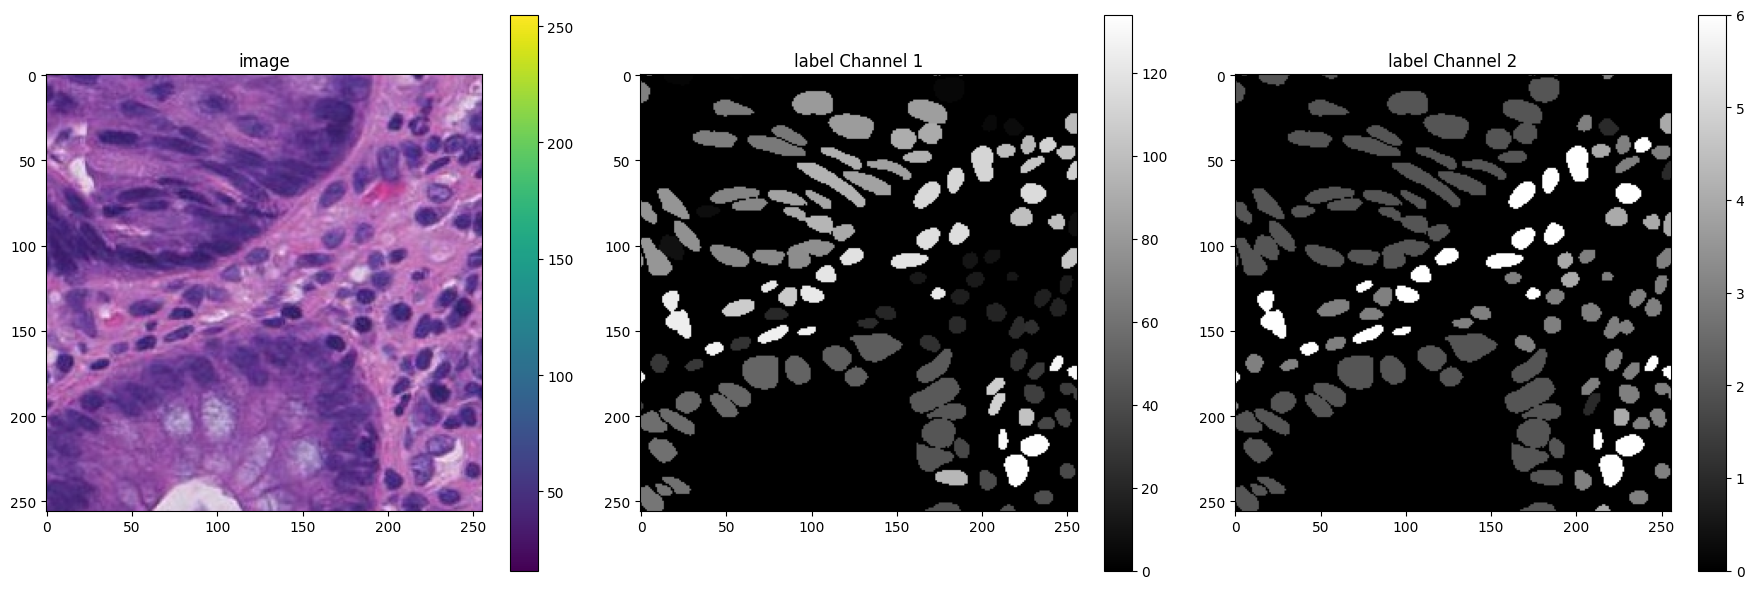

In [3]:
# Function to plot an individual channel
def plot_channel(img, title, ax, fig, cmap='gray'):
    im = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

# Function to plot image and its corresponding label
def plot_img_label(img, lbl, img_title="image", lbl_title="label"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust for 3 subplots

    # Plot the image
    if img.ndim == 2 or img.shape[-1] == 1:
        # Grayscale image
        plot_channel(img, img_title, axs[0], fig, cmap='gray')
    elif img.shape[-1] == 3:
        # RGB image
        plot_channel(img, img_title, axs[0], fig, cmap=None)

    # Plot each channel of the label separately
    for i in range(2):
        plot_channel(lbl[..., i], f"{lbl_title} Channel {i+1}", axs[i+1], fig)

    plt.tight_layout()

# Example usage
i = 3333
img, lbl = images[i], labels[i]
assert img.ndim in (2,3)
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]
plot_img_label(img, lbl)

In [4]:
# Filter out all cells except for Neutrophil cells:
classification_maps = labels[:, :, :, 1]

In [5]:
# Create binary masks for Neutrophil cells (class 1)
neutrophil_masks = (classification_maps == 1).astype(np.uint16)

In [6]:
# Assuming images is a list of your images and labels is a list of your labels
filtered_images = []
filtered_labels = []

for i in range(len(images)):
    # Check if the neutrophil mask contains any non-zero values (presence of neutrophil cells)
    if np.any(neutrophil_masks[i]):
        filtered_images.append(images[i])
        filtered_labels.append(neutrophil_masks[i])

# Replace the original lists with the filtered lists
images = filtered_images
labels = filtered_labels

In [7]:
print(f"Number of images: {len(images)} and labels: {len(labels)}")

Number of images: 1218 and labels: 1218


In [8]:
# If no third dim. then number of channels = 1.
n_channel = 1 if images[0].ndim == 2 else images[0].shape[-1]

In [9]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

images_norm = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(images)]

Normalizing image channels independently.


100%|██████████| 1218/1218 [00:04<00:00, 263.09it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


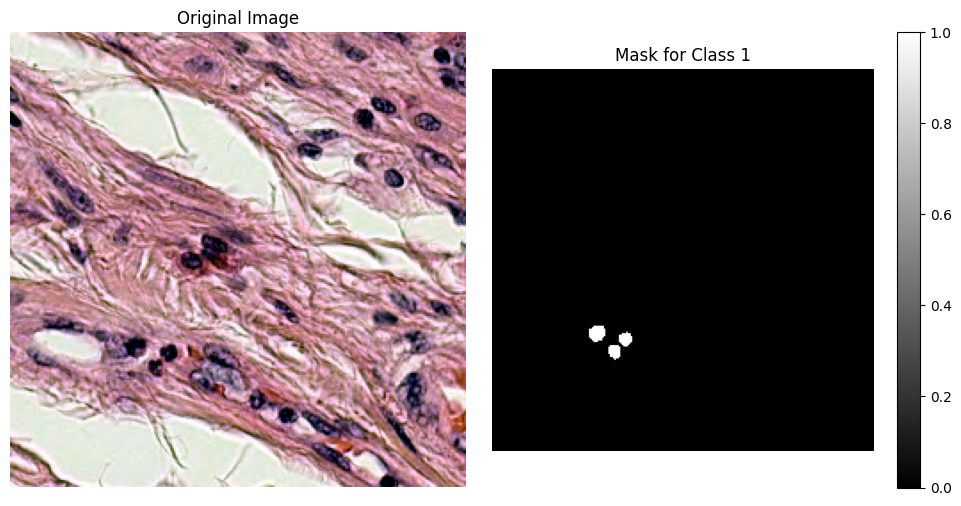

In [10]:
# Modified function to plot image and multiple mask channels
def plot_image_and_masks(image, masks, img_title="Original Image", lbl_title_base="Mask for Class"):
    # Determine the number of mask channels
    num_classes = masks.shape[-1] if masks.ndim == 3 else 1
    
    # Create subplots: one for the image and one for each mask channel
    fig, ax = plt.subplots(1, num_classes + 1, figsize=(5 * (num_classes + 1), 5))
    
    # Plot the original image
    ax[0].imshow(image)
    ax[0].set_title(img_title)
    ax[0].axis('off')
    
    # Plot each mask channel
    for i in range(num_classes):
        channel = masks[..., i] if num_classes > 1 else masks
        im = ax[i + 1].imshow(channel, cmap='gray')
        ax[i + 1].set_title(f"{lbl_title_base} {i+1}")
        ax[i + 1].axis('off')
        fig.colorbar(im, ax=ax[i + 1])  # Add a colorbar for each mask channel
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming images_norm and labels are already defined and labels have multiple channels)
plot_image_and_masks(images_norm[100], labels[100])

In [11]:
# Convert normalized images and masks to np.arrays
#images = np.array(images_norm)
#labels = np.array(labels)

In [12]:
unique_values = np.unique(labels)  # Inspect the second channel for unique values
unique_values

array([0, 1], dtype=uint16)

## Training

In [13]:
# Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    img = np.ascontiguousarray(img)  # Make a contiguous copy of the array
    mask = np.ascontiguousarray(mask)  # Make a contiguous copy of the array
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def random_resized_crop(img, mask, scale=(0.3, 0.7), ratio=(3. / 4., 4. / 3.), max_attempts=20):
    height, width = img.shape[:2]

    for attempt in range(max_attempts):
        target_area = np.random.uniform(*scale) * height * width
        target_ratio = np.random.uniform(*ratio)

        w = int(round(np.sqrt(target_area * target_ratio)))
        h = int(round(np.sqrt(target_area / target_ratio)))

        if np.random.uniform() < 0.5:
            w, h = h, w

        if w <= width and h <= height:
            x = np.random.randint(0, width - w + 1)
            y = np.random.randint(0, height - h + 1)

            img_cropped = img[y:y+h, x:x+w]
            mask_cropped = mask[y:y+h, x:x+w]

            img_resized = resize(img_cropped, (height, width), preserve_range=True, anti_aliasing=True).astype(img.dtype)
            mask_resized = resize(mask_cropped, (height, width), preserve_range=True, anti_aliasing=False).astype(mask.dtype)

            return img_resized, mask_resized

    # Fallback to central crop if no suitable crop is found
    center_crop = (slice(height//4, -height//4), slice(width//4, -width//4))
    img_cropped = img[center_crop]
    mask_cropped = mask[center_crop]

    img_resized = resize(img_cropped, (height, width), preserve_range=True, anti_aliasing=True).astype(img.dtype)
    mask_resized = resize(mask_cropped, (height, width), preserve_range=True, anti_aliasing=False).astype(mask.dtype)

    return img_resized, mask_resized

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Apply randomized resized crop first to ensure its effect is preserved
    x, y = random_resized_crop(x, y)

    # Then apply flipping and rotation, which will be less likely to undo the crop
    x, y = random_fliprot(x, y)

    # Apply intensity changes and gaussian noise last, as these are less spatially dependent
    x = random_intensity_change(x)
    sig = 0.02 * np.random.uniform(0, 1)
    x = x + sig * np.random.normal(0, 1, x.shape)

    x = np.ascontiguousarray(x)  # Make a contiguous copy of the array
    y = np.ascontiguousarray(y)  # Make a contiguous copy of the array
    return x, y

In [14]:
def create_augmented_dataset(images, masks, num_augmentations=1):
    augmented_images = []
    augmented_masks = []
    
    for img, mask in tqdm(zip(images, masks), total=len(images), desc='Augmenting images'):
        # Append original image and mask
        augmented_images.append(img)
        augmented_masks.append(mask)

        # Generate augmented versions
        for _ in range(num_augmentations):
            img_aug, mask_aug = augmenter(img, mask)
            augmented_images.append(img_aug)
            augmented_masks.append(mask_aug)

    # Convert to numpy arrays and clip to avoid negative values
    augmented_images = np.array(augmented_images).clip(0, 255).astype(np.uint8)
    augmented_masks = np.array(augmented_masks).clip(0, 1).astype(np.uint8)
    
    return augmented_images, augmented_masks

In [15]:
augmented_images, augmented_masks = create_augmented_dataset(images, labels, num_augmentations=3)

Augmenting images: 100%|██████████| 1218/1218 [00:48<00:00, 25.12it/s]


In [16]:
augmented_images.shape, augmented_masks.shape

((4872, 256, 256, 3), (4872, 256, 256))

In [17]:
# Define a simple U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
            nn.Sigmoid()  # Use Sigmoid to output probabilities for binary segmentation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define a Dataset class for your images and masks
class NeutrophilDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx].astype(np.float32)  # Convert to float32 before converting to tensor
        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension to mask
        return image, mask

# Transformations and DataLoader
transform = Compose([ToTensor()])

# Split the data into training and testing sets
images_train, images_test, masks_train, masks_test = train_test_split(
    augmented_images, augmented_masks, test_size=0.2, random_state=42
)

# Create training and testing datasets and dataloaders
train_dataset = NeutrophilDataset(images_train, masks_train, transform=transform)
test_dataset = NeutrophilDataset(images_test, masks_test, transform=transform)

# Print the number of samples in the training and testing datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)  # Batch size of 1 for testing

# Instantiate the U-Net model
model = UNet(in_channels=3, out_channels=1)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check model architecture
model

Number of training samples: 3897
Number of testing samples: 975


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [18]:
# Modify the training loop to include a validation step
def train_and_validate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=3):
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(test_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Validate]'):
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
        
        # Calculate average losses
        train_loss /= len(train_dataloader.dataset)
        val_loss /= len(test_dataloader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Save model if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')
            print("Model saved")

train_and_validate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=50)

Epoch 1/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.42it/s]


Epoch 1/50, Train Loss: 0.0305, Validation Loss: 0.0251
Model saved


Epoch 2/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 53.30it/s]


Epoch 2/50, Train Loss: 0.0261, Validation Loss: 0.0288


Epoch 3/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.86it/s]


Epoch 3/50, Train Loss: 0.0247, Validation Loss: 0.0229
Model saved


Epoch 4/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.43it/s]


Epoch 4/50, Train Loss: 0.0240, Validation Loss: 0.0220
Model saved


Epoch 5/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 53.10it/s]


Epoch 5/50, Train Loss: 0.0234, Validation Loss: 0.0244


Epoch 6/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 53.12it/s]


Epoch 6/50, Train Loss: 0.0231, Validation Loss: 0.0214
Model saved


Epoch 7/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.29it/s]


Epoch 7/50, Train Loss: 0.0230, Validation Loss: 0.0233


Epoch 8/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.06it/s]


Epoch 8/50, Train Loss: 0.0228, Validation Loss: 0.0212
Model saved


Epoch 9/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.67it/s]


Epoch 9/50, Train Loss: 0.0226, Validation Loss: 0.0214


Epoch 10/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 49.41it/s]


Epoch 10/50, Train Loss: 0.0223, Validation Loss: 0.0218


Epoch 11/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.42it/s]


Epoch 11/50, Train Loss: 0.0222, Validation Loss: 0.0208
Model saved


Epoch 12/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.59it/s]


Epoch 12/50, Train Loss: 0.0222, Validation Loss: 0.0208


Epoch 13/50 [Validate]: 100%|██████████| 975/975 [00:20<00:00, 47.96it/s]


Epoch 13/50, Train Loss: 0.0221, Validation Loss: 0.0208


Epoch 14/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.41it/s]


Epoch 14/50, Train Loss: 0.0221, Validation Loss: 0.0209


Epoch 15/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.62it/s]


Epoch 15/50, Train Loss: 0.0219, Validation Loss: 0.0207
Model saved


Epoch 16/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.46it/s]


Epoch 16/50, Train Loss: 0.0218, Validation Loss: 0.0205
Model saved


Epoch 17/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.61it/s]


Epoch 17/50, Train Loss: 0.0216, Validation Loss: 0.0208


Epoch 18/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.21it/s]


Epoch 18/50, Train Loss: 0.0216, Validation Loss: 0.0206


Epoch 19/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.04it/s]


Epoch 19/50, Train Loss: 0.0214, Validation Loss: 0.0200
Model saved


Epoch 20/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 49.69it/s]


Epoch 20/50, Train Loss: 0.0213, Validation Loss: 0.0201


Epoch 21/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.79it/s]


Epoch 21/50, Train Loss: 0.0212, Validation Loss: 0.0199
Model saved


Epoch 22/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.23it/s]


Epoch 22/50, Train Loss: 0.0212, Validation Loss: 0.0200


Epoch 23/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.39it/s]


Epoch 23/50, Train Loss: 0.0211, Validation Loss: 0.0197
Model saved


Epoch 24/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.09it/s]


Epoch 24/50, Train Loss: 0.0209, Validation Loss: 0.0199


Epoch 25/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.40it/s]


Epoch 25/50, Train Loss: 0.0210, Validation Loss: 0.0201


Epoch 26/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 49.06it/s]


Epoch 26/50, Train Loss: 0.0209, Validation Loss: 0.0201


Epoch 27/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.04it/s]


Epoch 27/50, Train Loss: 0.0208, Validation Loss: 0.0195
Model saved


Epoch 28/50 [Validate]: 100%|██████████| 975/975 [00:23<00:00, 42.21it/s]


Epoch 28/50, Train Loss: 0.0208, Validation Loss: 0.0200


Epoch 29/50 [Validate]: 100%|██████████| 975/975 [00:22<00:00, 44.06it/s]


Epoch 29/50, Train Loss: 0.0207, Validation Loss: 0.0195


Epoch 30/50 [Validate]: 100%|██████████| 975/975 [00:22<00:00, 43.44it/s]


Epoch 30/50, Train Loss: 0.0206, Validation Loss: 0.0194
Model saved


Epoch 31/50 [Validate]: 100%|██████████| 975/975 [00:22<00:00, 43.05it/s]


Epoch 31/50, Train Loss: 0.0205, Validation Loss: 0.0196


Epoch 32/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.34it/s]


Epoch 32/50, Train Loss: 0.0205, Validation Loss: 0.0193
Model saved


Epoch 33/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.34it/s]


Epoch 33/50, Train Loss: 0.0204, Validation Loss: 0.0192
Model saved


Epoch 34/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.06it/s]


Epoch 34/50, Train Loss: 0.0205, Validation Loss: 0.0195


Epoch 35/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 52.49it/s]


Epoch 35/50, Train Loss: 0.0204, Validation Loss: 0.0193


Epoch 36/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.50it/s]


Epoch 36/50, Train Loss: 0.0203, Validation Loss: 0.0191
Model saved


Epoch 37/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.01it/s]


Epoch 37/50, Train Loss: 0.0203, Validation Loss: 0.0199


Epoch 38/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.31it/s]


Epoch 38/50, Train Loss: 0.0202, Validation Loss: 0.0191
Model saved


Epoch 39/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.43it/s]


Epoch 39/50, Train Loss: 0.0202, Validation Loss: 0.0195


Epoch 40/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.75it/s]


Epoch 40/50, Train Loss: 0.0203, Validation Loss: 0.0190
Model saved


Epoch 41/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.18it/s]


Epoch 41/50, Train Loss: 0.0202, Validation Loss: 0.0194


Epoch 42/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.98it/s]


Epoch 42/50, Train Loss: 0.0201, Validation Loss: 0.0189
Model saved


Epoch 43/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.80it/s]


Epoch 43/50, Train Loss: 0.0201, Validation Loss: 0.0190


Epoch 44/50 [Validate]: 100%|██████████| 975/975 [00:20<00:00, 48.20it/s]


Epoch 44/50, Train Loss: 0.0200, Validation Loss: 0.0198


Epoch 45/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.86it/s]


Epoch 45/50, Train Loss: 0.0200, Validation Loss: 0.0188
Model saved


Epoch 46/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.14it/s]


Epoch 46/50, Train Loss: 0.0199, Validation Loss: 0.0193


Epoch 47/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.43it/s]


Epoch 47/50, Train Loss: 0.0200, Validation Loss: 0.0190


Epoch 48/50 [Validate]: 100%|██████████| 975/975 [00:18<00:00, 51.37it/s]


Epoch 48/50, Train Loss: 0.0199, Validation Loss: 0.0189


Epoch 49/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 50.99it/s]


Epoch 49/50, Train Loss: 0.0199, Validation Loss: 0.0206


Epoch 50/50 [Validate]: 100%|██████████| 975/975 [00:19<00:00, 51.00it/s]

Epoch 50/50, Train Loss: 0.0198, Validation Loss: 0.0188
Model saved


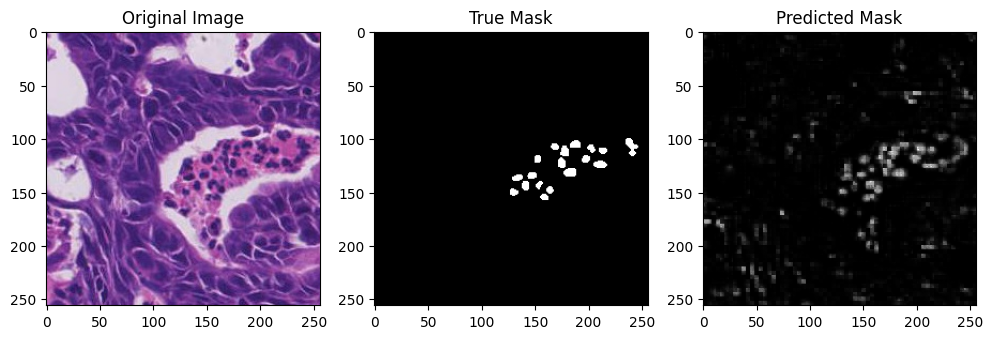

In [147]:
model.eval()
sample_idx = np.random.randint(len(test_dataset))
sample_image, sample_mask = test_dataset[sample_idx]
with torch.no_grad():
    prediction = model(sample_image.unsqueeze(0))[0]  # Add batch dimension and get first item

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0))  # Rearrange dimensions for plotting
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze(), cmap='gray')  # Remove channel dimension for plotting
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(prediction.squeeze().cpu().numpy(), cmap='gray')  # Convert to numpy and plot
plt.title('Predicted Mask')
plt.show()

## Testing

In [60]:
# Load the best model and evaluate it on the test set
model.load_state_dict(torch.load('models/best_model.pth'))

<All keys matched successfully>

In [62]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc='Evaluating'):
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

Evaluating: 100%|██████████| 975/975 [00:18<00:00, 52.09it/s]


In [63]:
# Calculate average test loss
test_loss /= len(test_dataloader.dataset)
print(f'Average test loss: {test_loss:.4f}')

Average test loss: 0.0188


In [65]:
# Calculate scores for the test set
model.eval()
dice_scores = []
with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc='Calculating Dice Scores'):
        outputs = model(images)
        outputs = outputs.squeeze().cpu().numpy()
        masks = masks.squeeze().cpu().numpy()
        intersection = np.logical_and(masks, outputs)
        dice = (2. * intersection.sum()) / (masks.sum() + outputs.sum())
        dice_scores.append(dice)

Calculating Dice Scores: 100%|██████████| 975/975 [00:21<00:00, 45.83it/s]


In [66]:
# Calculate average Dice score
mean_dice = np.mean(dice_scores)
print(f'Average Dice score: {mean_dice:.4f}')

Average Dice score: 0.6296
